<a href="https://colab.research.google.com/github/piyushy1/DeepLearningNotes/blob/master/Note4_LinearAlgebra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U d2l -f https://d2l.ai/whl.html

Looking in links: https://d2l.ai/whl.html
     |████████████████████████████████| 61kB 1.9MB/s 


In [2]:
%matplotlib inline
from d2l import torch as d2l
import math
import torch
import numpy as np
import time

In [5]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)
print(a.size())

torch.Size([10000])


In [6]:
class Timer:  #@save
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

In [7]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.10890 sec'

In [8]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00030 sec'

In [9]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

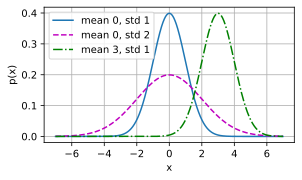

In [10]:
# Use numpy again for visualization
x = np.arange(-7, 7, 0.01)

# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

Linear Regression

In [ ]:
%matplotlib inline
from d2l import torch as d2l
import torch
import random

In [10]:
def synthetic_data(w, b, num_examples):  #@save
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [12]:
print(features[0], labels[0])

tensor([ 0.2620, -1.2401]) tensor([8.9370])


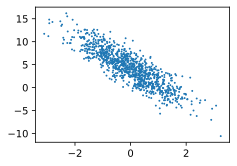

In [13]:
d2l.set_figsize()
# The semicolon is for displaying the plot only
d2l.plt.scatter(d2l.numpy(features[:, 1]), d2l.numpy(labels), 1);

In [18]:
import random
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [19]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.9672,  0.1362],
        [ 0.4040,  0.0877],
        [-1.3006, -1.5081],
        [-1.6869, -1.0509],
        [-2.0413,  0.0795],
        [ 1.7066,  0.0292],
        [-0.7883, -0.0566],
        [-0.5504, -0.0722],
        [-1.4454, -1.5507],
        [-0.8107, -0.8638]]) 
 tensor([[ 5.6693],
        [ 4.7015],
        [ 6.7283],
        [ 4.4060],
        [-0.1612],
        [ 7.5113],
        [ 2.8272],
        [ 3.3441],
        [ 6.5813],
        [ 5.5044]])


In [20]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [21]:
def linreg(X, w, b):  #@save
    """The linear regression model."""
    return torch.matmul(X, w) + b

In [22]:
def squared_loss(y_hat, y):  #@save
    """Squared loss."""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [23]:
def sgd(params, lr, batch_size):  #@save
    """Minibatch stochastic gradient descent."""
    for param in params:
        param.data.sub_(lr*param.grad/batch_size)
        param.grad.data.zero_()

In [28]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`
        # Compute gradient on `l` with respect to [`w`, `b`]
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.000049
epoch 2, loss 0.000049
epoch 3, loss 0.000049


In [25]:
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([ 0.0003, -0.0006], grad_fn=<SubBackward0>)
error in estimating b: tensor([3.1948e-05], grad_fn=<RsubBackward1>)


Linear Reggression in Concise

In [3]:
from d2l import torch as d2l
import numpy as np
import torch
from torch.utils import data

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [4]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [5]:
# `nn` is an abbreviation for neural networks
from torch import nn
net = nn.Sequential(nn.Linear(2, 1))

In [6]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [7]:
loss = nn.MSELoss()

In [8]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [9]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000187
epoch 2, loss 0.000105
epoch 3, loss 0.000104


In [2]:
from d2l import torch as d2l
import torch
from torch import nn

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw


Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [3]:
# PyTorch does not implicitly reshape the inputs. Thus we define a layer to
# reshape the inputs in our network
class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1,784)

net = nn.Sequential(Reshape(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Reshape()
  (1): Linear(in_features=784, out_features=10, bias=True)
)

In [4]:
loss = nn.CrossEntropyLoss()

In [9]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

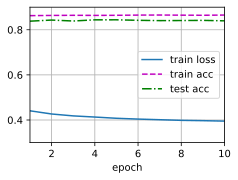

In [10]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)